This notebook allows to train models pretrained on imagenet.
Images should be placed in folder. If you don't have extracted images go to 'BSON to files' notebook and run it first.

## 0. Imports, ultils

In [33]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, merge
from keras.layers.core import Lambda
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, Callback
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.optimizers import RMSprop, Adam, SGD
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import random, csv
import numpy as np 


num_classes = 5270

img_width = 180
img_height = 180

train_imgs_folder = './data/files/train'
valid_imgs_folder = './data/files/valid'

In [9]:
def my_preprocessing(x):
    """
    Add special augmentation: random cropping and random shuffling of color channels
    """
    #random cropping
    output_size = (180,180)
    w, h, c = x.shape
    th, tw = output_size
    h_diff = h - th
    w_diff = w - tw
    i = random.randint(0, h_diff)
    j = random.randint(0, w_diff)
    x= x[j:j + tw, i:i + th,:]
    #shuffle channels
    a = np.arange(3) 
    np.random.shuffle(a)
    x_new = x[:,:,a]
    return preprocess_input(x_new)

### Checking that image augmentation works fine

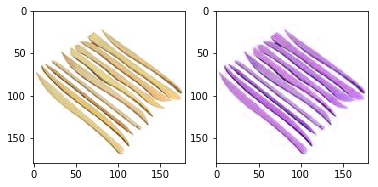

In [29]:
img = image.load_img('/home/pon/kaggle/data/files/train_single/1000022419/541291-0.jpg')
x = image.img_to_array(img)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
x = my_preprocessing(x)
plt.imshow(image.array_to_img(x))
plt.show()

### Utils

In [22]:
def add_new_last_layer(base_model, nb_classes):
    """
    Add new layers to use models with other number of classes
    """
    #add new layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x) #new global pooling layer layer
    x = Dropout(0.2)(x) # dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=predictions)
    return model

In [ ]:
def make_parallel(model, gpu_count):
    """
    Devide batch between GPUs and merge on CPU
    """
    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([ shape[:1] // parts, shape[1:] ],axis=0)
        stride = tf.concat([ shape[:1] // parts, shape[1:]*0 ],axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    #Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                #Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx':i,'parts':gpu_count})(x)
                    inputs.append(slice_n)                
                outputs = model(inputs)
                
                if not isinstance(outputs, list):
                    outputs = [outputs]
                
                #Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(merge(outputs, mode='concat', concat_axis=0))
            
        new_model = Model(input=model.inputs, output=merged)
        ## to save initial model
        funcType = type(model.save)
        # monkeypatch the save to save just the underlying model
        def new_save(self_,filepath, overwrite=True):
            model.save(filepath, overwrite)
        new_model.save=funcType(new_save, new_model)
        return new_model

# 1. Xception/InceptionResNetV2 models fine-tuning.
Learning rates where changed manualy from 0.02 to 0.00001. 
Best optimization algorithm - SGD. RMSprop and Adam don't converge.

#### Load pretrained on Imagenet model and fine-tune last layer.

In [30]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3)) 
model = add_new_last_layer(base_model, num_classes)
sgd = SGD(lr=0.02, momentum=0.9, nesterov=True)
for layer in base_model.layers:
    layer.trainable = False
model = make_parallel(model, 2)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 180, 180, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_20 (Lambda)              (None, 180, 180, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
model_9 (Model)                 (None, 5270)         31659710    lambda_19[0][0]                  
                                                                 lambda_20[0][0]                  
__________

/home/pon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/pon/.local/lib/python3.5/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


### Train model 

In [ ]:
batch_size = 48 * 2

#parameters used for model names were described in spreadsheet
model_name = '96'

#use spetial augmentation described earlier
datagen_train = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=(0.8, 1.05),
    horizontal_flip=True,
    preprocessing_function=my_preprocessing
    #preprocessing_function=preprocess_input
)

datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
##TODO: Check that the number of images % number of GPU = 0. Delete some images otherwise

train_generator = datagen_train.flow_from_directory(
        train_imgs_folder,
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size)

valid_generator = datagen_test.flow_from_directory(
        valid_imgs_folder,
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size)

#write loss to file every batch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_epoch_end(self, epoch, logs={}):
        with open('.logs/' + model_name + '.csv', 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(self.losses)
            
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()

checkpointer = ModelCheckpoint(monitor='val_loss',
                             filepath= '.models_checkpoints/' + model_name + '_{epoch:03d}-{val_loss:.5f}.hdf5',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='max')

csv_logger = CSVLogger('training2.log')

model.fit_generator(
    train_generator,
    epochs=12,
    steps_per_epoch=11752162//batch_size,#263127-train_small_single, #6041888- train_single_aug
    validation_data=valid_generator,
    validation_steps=619128//batch_size,#354080 - valid_single, 14064 - valid_small_single
    max_queue_size = 20, #encrese for more powerfull machine
    workers = 16, #encrese for more powerfull machine
    callbacks = [checkpointer, csv_logger, history],
    initial_epoch = 11) # set new initial epoch

#Save trained model om disk
model.save("models/"+ model_name +".h5")

#### Load saved model, train the whole model gradually decresing learning rate. To train next epoch(s) comeback to previous cell

In [ ]:
with tf.device('/cpu:0'):
    model = load_model("models/95_009-1.51510.hdf5")
    for layer in model.layers:
        layer.trainable = True
    sgd = SGD(lr=0.005, momentum=0.9, nesterov=True)
model = make_parallel(model, 2)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#### Look at the grath of decresing loss and change learning rate appropriatly

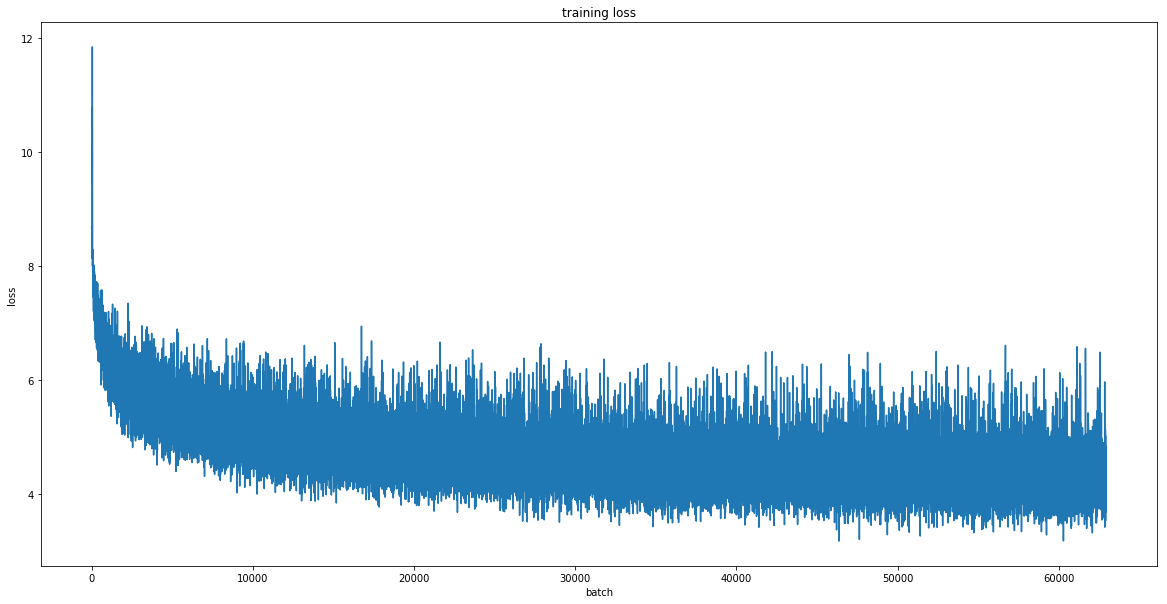

In [126]:
plt.figure(figsize = (20, 10))
plt.plot(history.losses)
plt.title('training loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()